# Feb 15th, 2022 (Smart adj plot)

**Motivation**: Group nodes together: Visual, Medial, Frontal, Somatomotor. <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


from scipy.ndimage import gaussian_filter

def show_h(proj_h, proj_hr, idx: int = 0, cmap='icefire', interp='antialiased'):
    fig, axes = create_figure(
        1, 4, (10., 2), width_ratios=[1.7, 1, 1, 1.7])

    x2plt = proj_h['flat'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[0].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[0], shrink=0.4)

    x2plt = proj_h['top'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[1].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['top'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[2].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['flat'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[3].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[3], shrink=0.4)

    remove_ticks(axes)
    plt.show()

In [3]:
mice = Mice(128)

In [4]:
res = sort_nodes(mice)

In [5]:
f = 'parcel2d-top_10um.nii.gz'
f = pjoin(mice.cfg.parcel_dir, f)
parcel_top = ants.image_read(f, pixeltype='unsigned int')
parcel_top = parcel_top.numpy()

f = 'parcel2d-flat_10um.nii.gz'
f = pjoin(mice.cfg.parcel_dir, f)
parcel_flat = ants.image_read(f, pixeltype='unsigned int')
parcel_flat = parcel_flat.numpy()

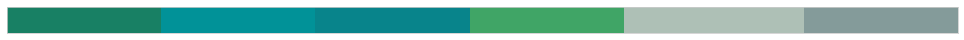

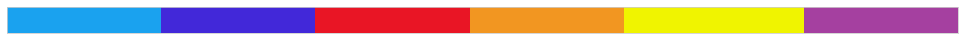

In [6]:
cmap_allen = get_affiliation_cmap()
cmap = get_affiliation_cmap(False)
display_cmap(cmap_allen)
display_cmap(cmap)

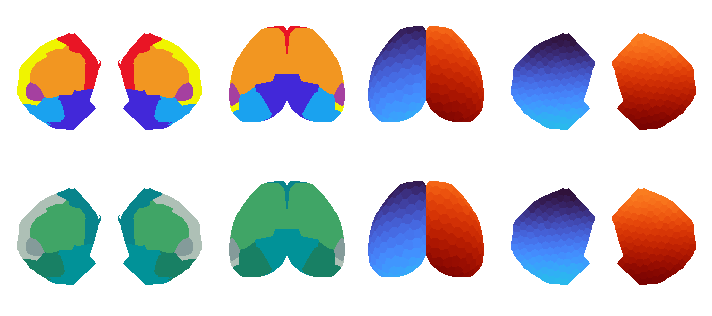

In [7]:
fig, axes = create_figure(2, 4, (10, 4.5), width_ratios=[1.6, 1, 1, 1.6])
for i, cm in enumerate([cmap, cmap_allen]):
    x2plt = np.ma.masked_where(res['obj_flat'] == 0, res['obj_flat'])
    axes[i, 0].imshow(x2plt, cmap=cm)
    x2plt = np.ma.masked_where(res['obj_top'] == 0, res['obj_top'])
    axes[i, 1].imshow(x2plt, cmap=cm);
    x2plt = np.ma.masked_where(parcel_top == 0, parcel_top)
    axes[i, 2].imshow(x2plt, cmap='turbo')
    x2plt = np.ma.masked_where(parcel_flat == 0, parcel_flat)
    axes[i, 3].imshow(x2plt, cmap='turbo')
remove_ticks(axes)
plt.show()

In [8]:
base = Base(mice, mode='ca2', prep_data=False, apply_tmask=False)

In [9]:
regions = np.unique(parcel_flat[parcel_flat.nonzero()])
hcl = mice.parcel.decode(regions)
regions_l = mice.parcel.encode(hcl[hcl[:, 0] == 1])
regions_r = mice.parcel.encode(hcl[hcl[:, 0] == 2])

regions_included_l = [
    mice.parcel.encode(lbl) for n, lbl in
    base.n2l.items() if n in base.l_ids
]

In [10]:
affil_max_flat = np.zeros_like(parcel_flat)
for r, affil in res['regions_affil_max'].items():
    affil_max_flat[parcel_flat == r] = list(res['affiliation']).index(affil) + 1

m = np.isin(parcel_flat, regions_r)
affil_max_flat[m] = res['obj_flat'][m]

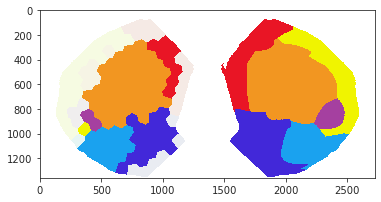

In [11]:
x2plt = np.ma.masked_where(affil_max_flat == 0, affil_max_flat)
plt.imshow(x2plt, cmap=cmap)

mask = np.zeros(parcel_flat.shape)
mask[np.isin(parcel_flat, regions_l)] = 1
mask[np.isin(parcel_flat, regions_included_l)] = 0
x2plt = np.ma.masked_where(mask == 0, mask)
plt.imshow(x2plt, cmap='Greens', alpha=0.93)
plt.show()

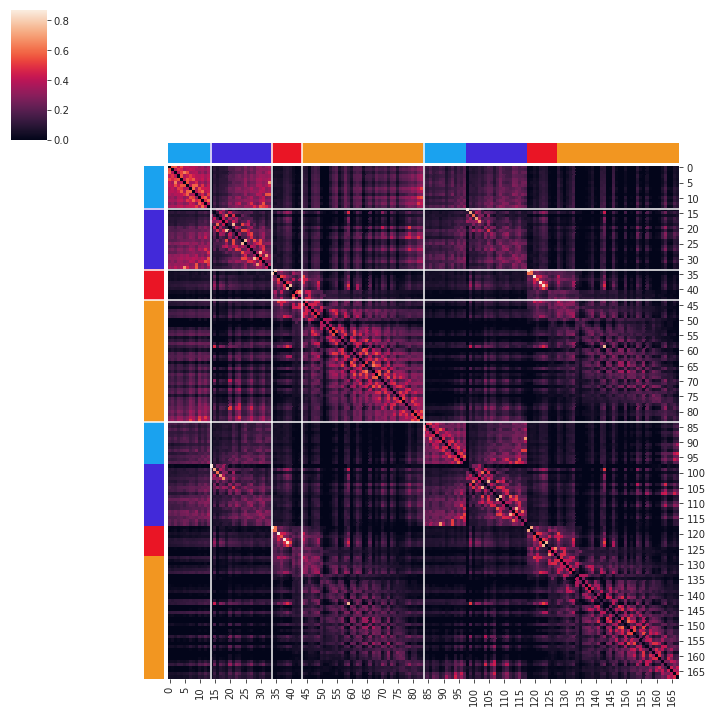

In [12]:
cg = sns.clustermap(
    data=res['a_bold'][res['sort_ids_lr']][:, res['sort_ids_lr']],
    row_colors=res['clist'] * 2,
    col_colors=res['clist'] * 2,
    row_cluster=False,
    col_cluster=False,
    cmap='rocket',
)
xline = 0
for name in res['major_labels']:
    xline += len(res['g2l'][name])
    if xline > len(res['sort_ids_l']):
        break
    cg.ax_heatmap.axvline(xline, color='white')
    cg.ax_col_colors.axvline(xline, color='white')

    cg.ax_heatmap.axhline(xline, color='white')
    cg.ax_row_colors.axhline(xline, color='white')

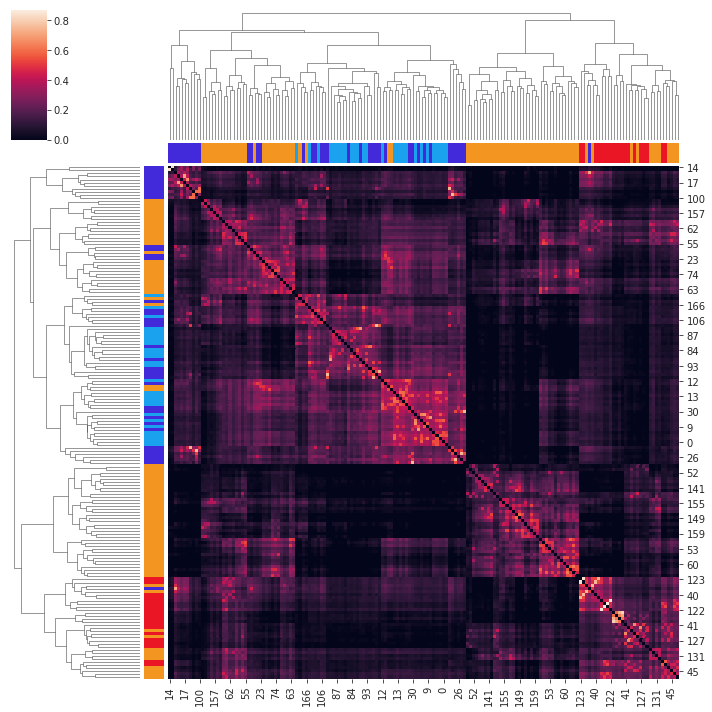

In [13]:
cg = sns.clustermap(
    data=res['a_bold'][res['sort_ids_lr']][:, res['sort_ids_lr']],
    row_colors=res['clist'] * 2,
    col_colors=res['clist'] * 2,
    cmap='rocket',
);

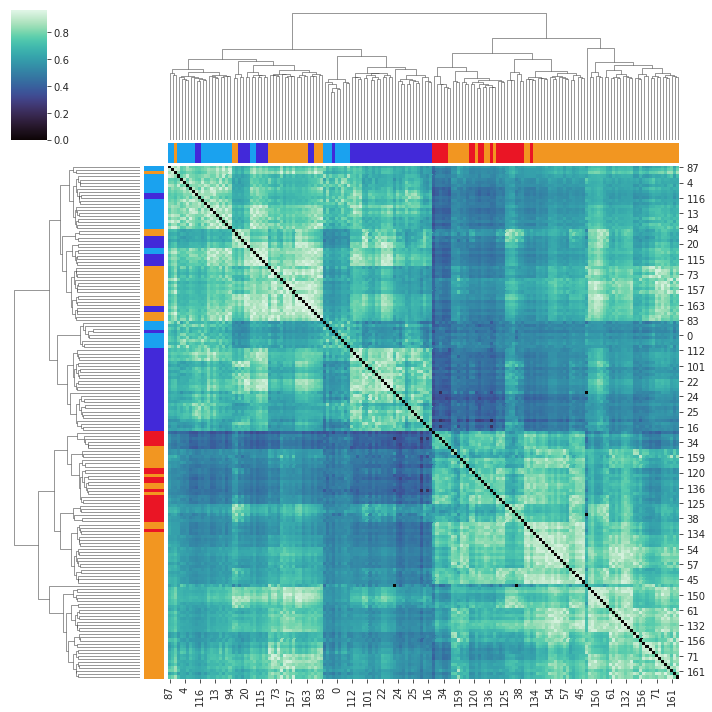

In [14]:
cg = sns.clustermap(
    data=res['a_ca'][res['sort_ids_lr']][:, res['sort_ids_lr']],
    row_colors=res['clist'] * 2,
    col_colors=res['clist'] * 2,
    cmap='mako',
);

## Finalize

### BOLD-Lite

In [15]:
a_sort = res['a_bold'][res['sort_ids_lr']][:, res['sort_ids_lr']]
inter, intra = base.get_inter_intra(a_sort)
vmin = min(np.min(intra), np.min(inter))
vmax = max(np.max(intra), np.max(inter))
vmin, vmax

(0.0, 1.0)

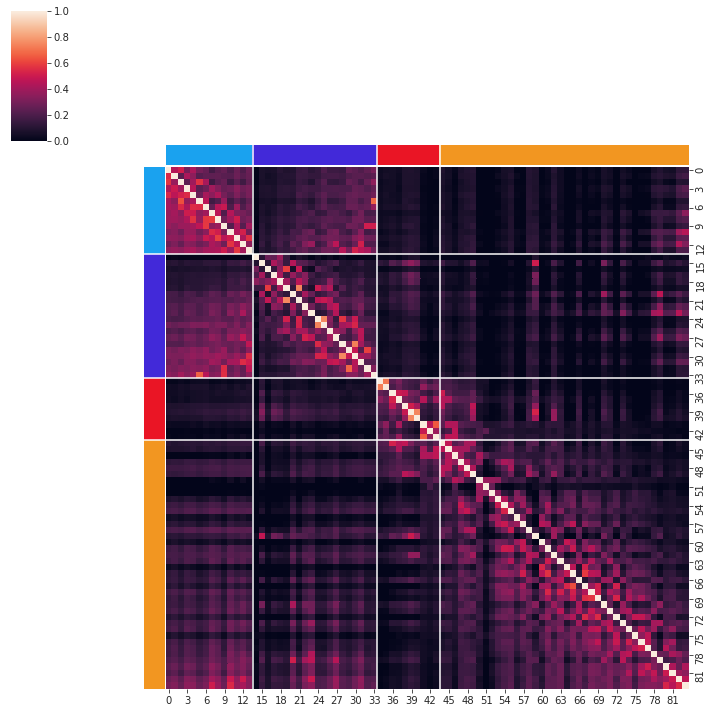

In [16]:
cg = sns.clustermap(
    data=intra,
    row_colors=res['clist'],
    col_colors=res['clist'],
    row_cluster=False,
    col_cluster=False,
    cmap='rocket',
    vmin=vmin,
    vmax=vmax,
)
xline = 0
for name in res['major_labels']:
    xline += len(res['g2l'][name])
    if xline >= len(res['sort_ids_l']):
        break
    cg.ax_heatmap.axvline(xline, color='white')
    cg.ax_col_colors.axvline(xline, color='white')

    cg.ax_heatmap.axhline(xline, color='white')
    cg.ax_row_colors.axhline(xline, color='white')

In [17]:
intra, inter = map(np.arctanh, (intra, inter))
intra[~np.isfinite(intra)] = 0.0
inter[~np.isfinite(inter)] = 0.0
vmin = min(np.min(intra), np.min(inter))
vmax = max(np.max(intra), np.max(inter))
vmin, vmax

(0.0, 1.3165908620584075)

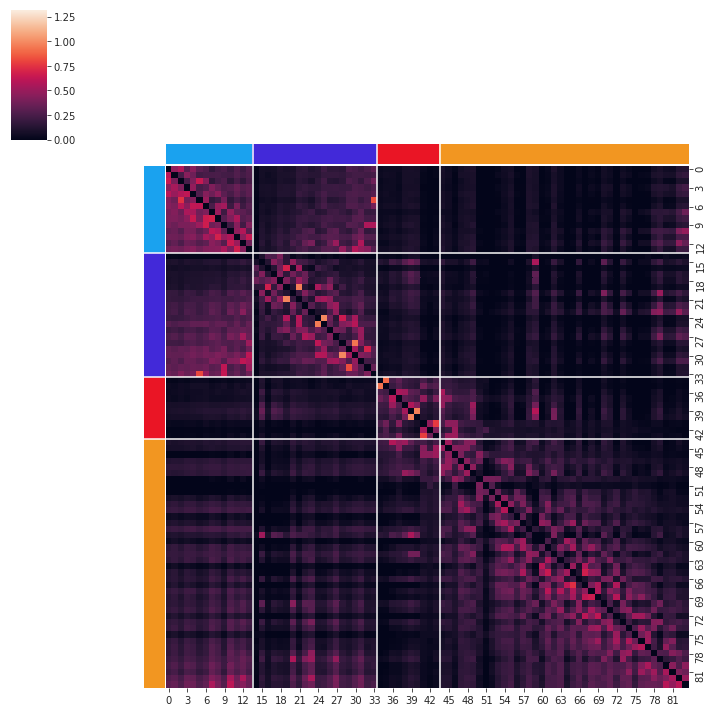

In [18]:
cg = sns.clustermap(
    data=intra,
    row_colors=res['clist'],
    col_colors=res['clist'],
    row_cluster=False,
    col_cluster=False,
    cmap='rocket',
    vmin=vmin,
    vmax=vmax,
)
xline = 0
for name in res['major_labels']:
    xline += len(res['g2l'][name])
    if xline >= len(res['sort_ids_l']):
        break
    cg.ax_heatmap.axvline(xline, color='white')
    cg.ax_col_colors.axvline(xline, color='white')

    cg.ax_heatmap.axhline(xline, color='white')
    cg.ax_row_colors.axhline(xline, color='white')

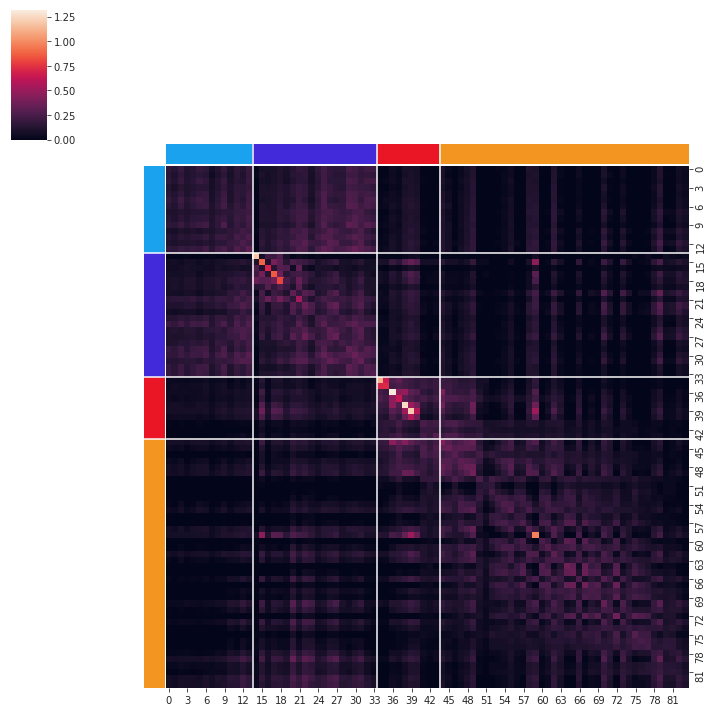

In [19]:
cg = sns.clustermap(
    data=inter,
    row_colors=res['clist'],
    col_colors=res['clist'],
    row_cluster=False,
    col_cluster=False,
    cmap='rocket',
    vmin=vmin,
    vmax=vmax,
)
xline = 0
for name in res['major_labels']:
    xline += len(res['g2l'][name])
    if xline >= len(res['sort_ids_l']):
        break
    cg.ax_heatmap.axvline(xline, color='white')
    cg.ax_col_colors.axvline(xline, color='white')

    cg.ax_heatmap.axhline(xline, color='white')
    cg.ax_row_colors.axhline(xline, color='white')

### CA2

In [20]:
a_sort = res['a_ca'][res['sort_ids_lr']][:, res['sort_ids_lr']]
inter, intra = base.get_inter_intra(a_sort)
vmin = min(np.min(intra), np.min(inter))
vmax = max(np.max(intra), np.max(inter))
vmin, vmax

(0.0, 1.0)

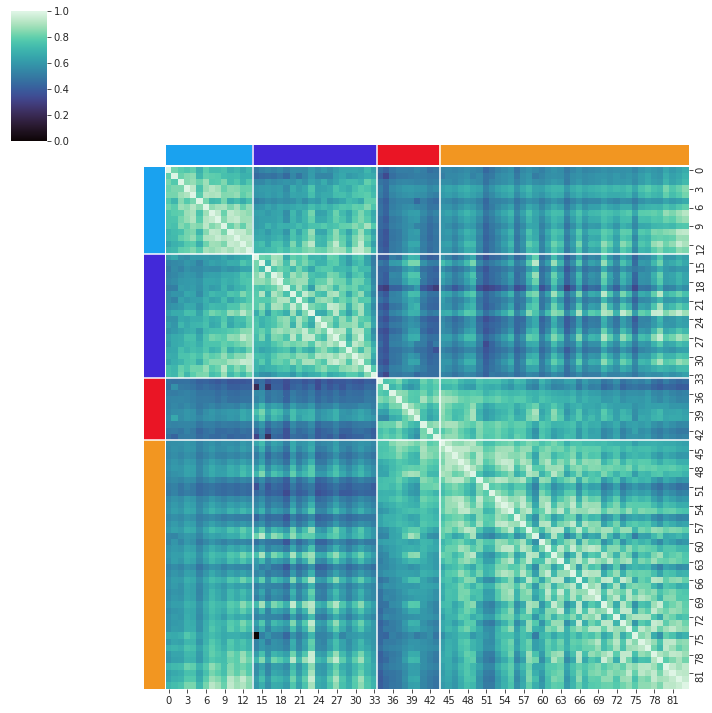

In [21]:
cg = sns.clustermap(
    data=intra,
    row_colors=res['clist'],
    col_colors=res['clist'],
    row_cluster=False,
    col_cluster=False,
    cmap='mako',
    vmin=vmin,
    vmax=vmax,
)
xline = 0
for name in res['major_labels']:
    xline += len(res['g2l'][name])
    if xline >= len(res['sort_ids_l']):
        break
    cg.ax_heatmap.axvline(xline, color='white')
    cg.ax_col_colors.axvline(xline, color='white')

    cg.ax_heatmap.axhline(xline, color='white')
    cg.ax_row_colors.axhline(xline, color='white')

In [22]:
intra, inter = map(np.arctanh, (intra, inter))
intra[~np.isfinite(intra)] = 0.0
inter[~np.isfinite(inter)] = 0.0
vmin = min(np.min(intra), np.min(inter))
vmax = max(np.max(intra), np.max(inter))
vmin, vmax

(0.0, 2.0061810666814868)

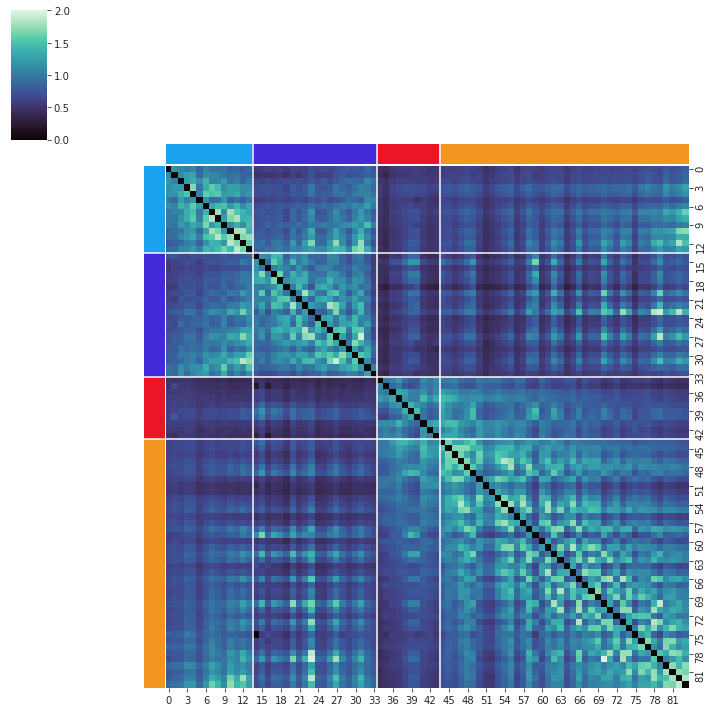

In [23]:
cg = sns.clustermap(
    data=intra,
    row_colors=res['clist'],
    col_colors=res['clist'],
    row_cluster=False,
    col_cluster=False,
    cmap='mako',
    vmin=vmin,
    vmax=vmax,
)
xline = 0
for name in res['major_labels']:
    xline += len(res['g2l'][name])
    if xline >= len(res['sort_ids_l']):
        break
    cg.ax_heatmap.axvline(xline, color='white')
    cg.ax_col_colors.axvline(xline, color='white')

    cg.ax_heatmap.axhline(xline, color='white')
    cg.ax_row_colors.axhline(xline, color='white')

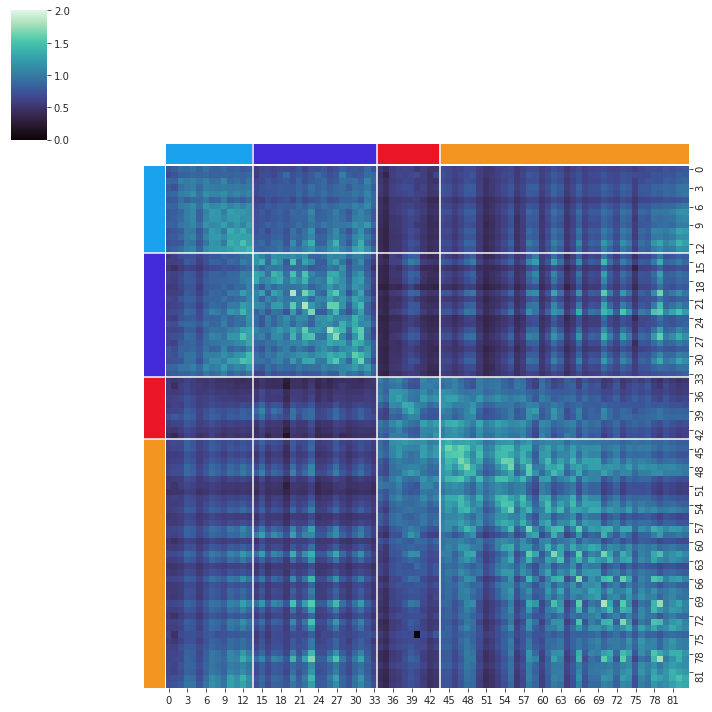

In [24]:
cg = sns.clustermap(
    data=inter,
    row_colors=res['clist'],
    col_colors=res['clist'],
    row_cluster=False,
    col_cluster=False,
    cmap='mako',
    vmin=vmin,
    vmax=vmax,
)
xline = 0
for name in res['major_labels']:
    xline += len(res['g2l'][name])
    if xline >= len(res['sort_ids_l']):
        break
    cg.ax_heatmap.axvline(xline, color='white')
    cg.ax_col_colors.axvline(xline, color='white')

    cg.ax_heatmap.axhline(xline, color='white')
    cg.ax_row_colors.axhline(xline, color='white')

## Old (ignore)

<matplotlib.image.AxesImage object at 0x7fdf01d6cf10>

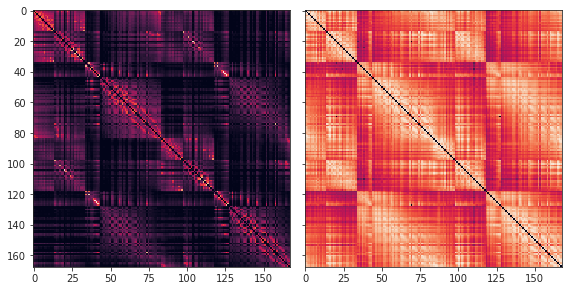

In [105]:
fig, axes = create_figure(1, 2, (8, 6), 'all', 'all')
axes[0].imshow(a_bold[sort_ids_lr][:, sort_ids_lr])
axes[1].imshow(a_ca[sort_ids_lr][:, sort_ids_lr])

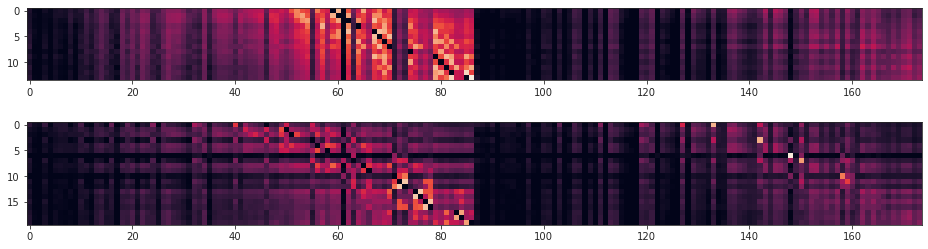

In [112]:
fig, axes = create_figure(2, 1, (13, 4))
axes[0].imshow(a_bold[sort_l['Visual']])
axes[1].imshow(a_bold[sort_l['Medial']]);

In [164]:
db = sp_dist.cdist(
    XA=a_bold[sort_l['Visual']],
    XB=a_bold[sort_l['Medial']],
    metric='correlation',
)
dc = sp_dist.cdist(
    XA=a_ca[sort_l['Visual']],
    XB=a_ca[sort_l['Medial']],
    metric='correlation',
)
davg = (db + dc) / 2

In [165]:
db.shape

(14, 20)

<matplotlib.image.AxesImage object at 0x7fdf01201a60>

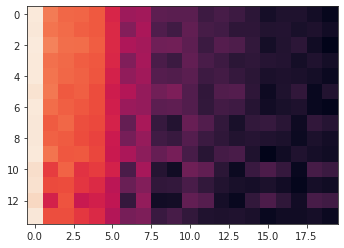

In [166]:
plt.imshow(db)

<matplotlib.image.AxesImage object at 0x7fdf0159aa00>

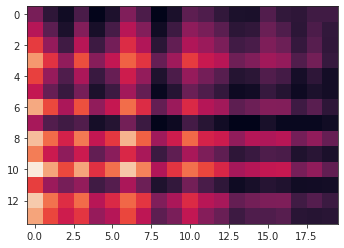

In [131]:
plt.imshow(dc)

[<matplotlib.lines.Line2D object at 0x7fdf01559b80>]

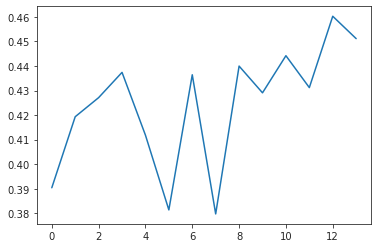

In [132]:
plt.plot(db.mean(1))

In [135]:
idsb1 = np.argsort(db.mean(1))[::-1]
idsb2 = np.argsort(db.mean(0))[::-1]

<matplotlib.image.AxesImage object at 0x7fdf00f1d880>

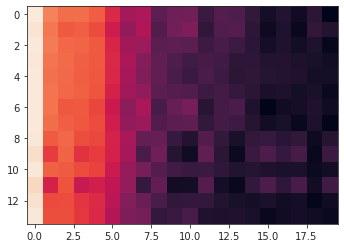

In [136]:
plt.imshow(db[idsb1][:, idsb2])

In [137]:
idsc1 = np.argsort(dc.mean(1))[::-1]
idsc2 = np.argsort(dc.mean(0))[::-1]

<matplotlib.image.AxesImage object at 0x7fdf011d6160>

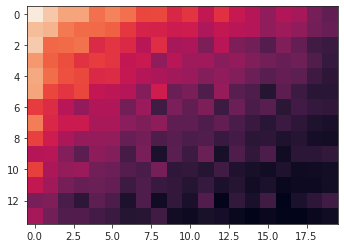

In [138]:
plt.imshow(dc[idsc1][:, idsc2])

In [139]:
idsc1, idsb1

(
    array([10,  8, 12,  3,  6, 13,  2,  9,  4,  1, 11,  5,  0,  7]),
    array([12, 13, 10,  8,  3,  6, 11,  9,  2,  1,  4,  0,  5,  7])
)

<matplotlib.image.AxesImage object at 0x7fdf00ed88e0>

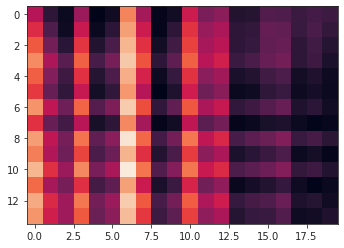

In [141]:
davg = (db + dc) / 2
plt.imshow(davg)

In [142]:
ids1 = np.argsort(davg.mean(1))[::-1]
ids2 = np.argsort(davg.mean(0))[::-1]

<matplotlib.image.AxesImage object at 0x7fdf0140b940>

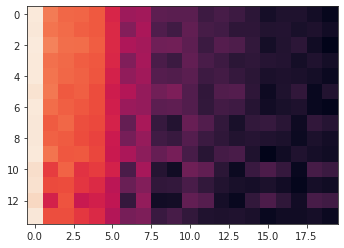

In [143]:
plt.imshow(db[ids1][:, ids2])

<matplotlib.image.AxesImage object at 0x7fdf012b7280>

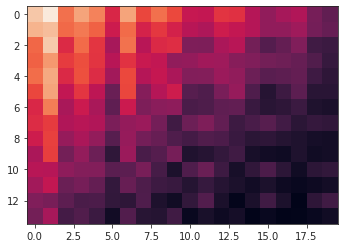

In [144]:
plt.imshow(dc[ids1][:, ids2])

## Grp (also ignore)

In [25]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.65), 'bold-lite': rocket(0.6)}

props_base = {
    'num_k': 5,
    'perc': 'p10-sample',
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bold = {'mode': 'bold-lite', **props_base}

In [26]:
gr_ca = Group(**props_ca).fit_group()
gr_bold = Group(**props_base).fit_group()

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

ids

[0, 1, 2, 3, 4]

In [27]:
h_bold = sp_stats.entropy(gr_bold.grp_pi_prune) / np.log(gr_bold.num_k)
h_ca = sp_stats.entropy(gr_ca.grp_pi_prune) / np.log(gr_ca.num_k)
h_both = (h_bold + h_ca) / 2
hr_both = sp_stats.rankdata(h_both)

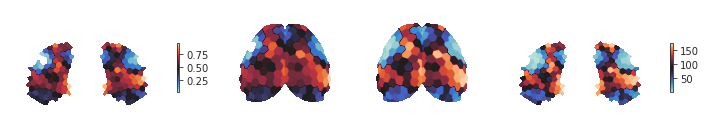

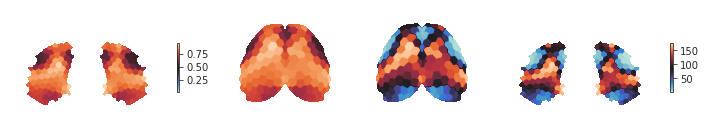

In [28]:
show_h(
    gr_bold.project_vec(h_bold, add_disjoint=False),
    gr_bold.project_vec(sp_stats.rankdata(h_bold), add_disjoint=False),
)
show_h(
    gr_bold.project_vec(gr_bold.grp_h, add_disjoint=False),
    gr_bold.project_vec(gr_bold.grp_hr, add_disjoint=False),
)

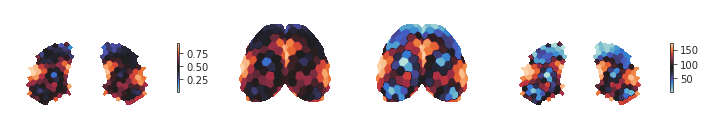

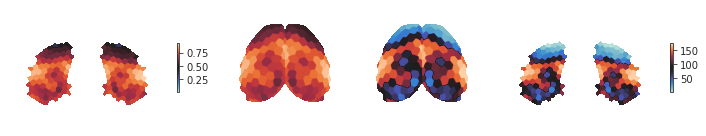

In [29]:
show_h(
    gr_ca.project_vec(h_ca, add_disjoint=False),
    gr_ca.project_vec(sp_stats.rankdata(h_ca), add_disjoint=False),
)
show_h(
    gr_ca.project_vec(gr_ca.grp_h, add_disjoint=False),
    gr_ca.project_vec(gr_ca.grp_hr, add_disjoint=False),
)

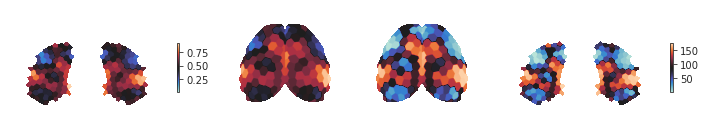

In [30]:
show_h(
    gr_ca.project_vec(h_both, add_disjoint=False),
    gr_ca.project_vec(sp_stats.rankdata(h_both), add_disjoint=False),
)

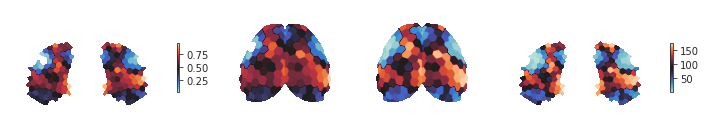

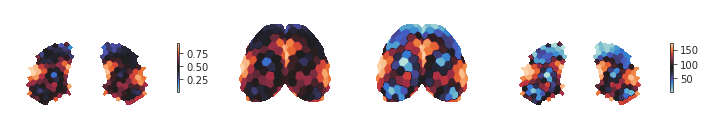

In [31]:
show_h(
    gr_bold.project_vec(h_bold, add_disjoint=False),
    gr_bold.project_vec(sp_stats.rankdata(h_bold), add_disjoint=False),
)
show_h(
    gr_ca.project_vec(h_ca, add_disjoint=False),
    gr_ca.project_vec(sp_stats.rankdata(h_ca), add_disjoint=False),
)

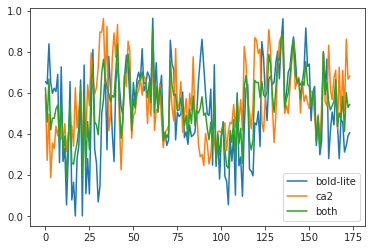

In [32]:
plt.plot(h_bold, label='bold-lite')
plt.plot(h_ca, label='ca2')
plt.plot(h_both, label='both')
plt.legend()
plt.show()

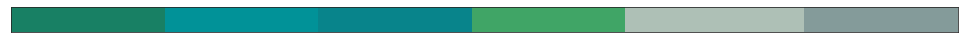

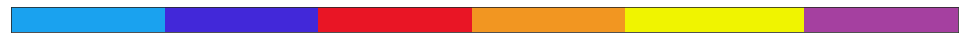

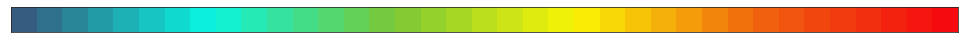

In [33]:
cmap_allen, clist_allen = get_affiliation_cmap(use_allen=True, return_clist=True)
cmap, clist = get_affiliation_cmap(use_allen=False, return_clist=True)
cmap_adj = get_hm_cmap()
display_cmap(cmap_allen)
display_cmap(cmap)
display_cmap(cmap_adj)

In [43]:
major_labels = list(affiliation)[:4]
major_labels

['Visual', 'Medial', 'Prefrontal', 'Somatomotor']

In [44]:
net = Network(mice, mode='bold-lite').load_network(full=False)
a = net.adj.copy()
a[a < 0] = 0

In [45]:
colors = []
sort_l = []
for i, name in enumerate(major_labels):
    x = [
        n for n, lbl in net.n2l.items() if
        (lbl in g2l[name] and n in net.l_ids)
    ]
    x = np.array([net.l2n[lbl] for lbl in g2l[name]])
    # if name in ['Somatomotor']:
    #     x = x[np.argsort(h_both[x])[::-1]]
    # elif name in ['Visual']:
    #     x = x[np.argsort(h_both[x])]
    colors += [clist[i]] * len(x)
    sort_l += list(x)
sort_l = np.array(sort_l)

In [46]:
sort_l

array([59, 60, 62, 64, 67, 68, 69, 70, 74, 79, 80, 81, 82, 85, 46, 50, 51,
       55, 56, 58, 61, 63, 65, 66, 71, 72, 73, 75, 76, 77, 78, 83, 84, 86,
        0,  1,  3,  5,  6, 10, 16, 24, 32, 33,  2,  4,  7,  8,  9, 11, 12,
       13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 49, 52, 53])

In [47]:
sort_lr = np.concatenate([sort_l, sort_l + len(net.n2l) // 2])

In [48]:
intra_l = a[net.l_ids][:, net.l_ids]
intra_r = a[net.r_ids][:, net.r_ids]

intra = intra_l.copy()
upper = np.triu_indices_from(intra_l)
intra[upper] = intra_r[upper]
np.fill_diagonal(intra, 1.0)

inter = a[net.l_ids][:, net.r_ids]

intra, inter = map(np.arctanh, (intra, inter))
intra[~np.isfinite(intra)] = 0.0
inter[~np.isfinite(inter)] = 0.0

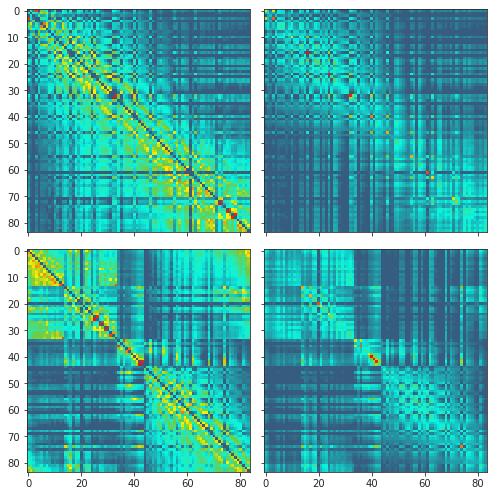

In [49]:
fig, axes = create_figure(2, 2, (7, 7), 'all', 'all')
axes[0, 0].imshow(intra, cmap=cmap_adj)
axes[0, 1].imshow(inter, cmap=cmap_adj)

axes[1, 0].imshow(intra[sort_l][:, sort_l], cmap=cmap_adj)
axes[1, 1].imshow(inter[sort_l][:, sort_l], cmap=cmap_adj)

plt.show()

In [50]:
vmin = min(np.min(intra), np.min(inter))
vmax = max(np.max(intra), np.max(inter))
vmin, vmax

(0.0, 1.3651368457827562)

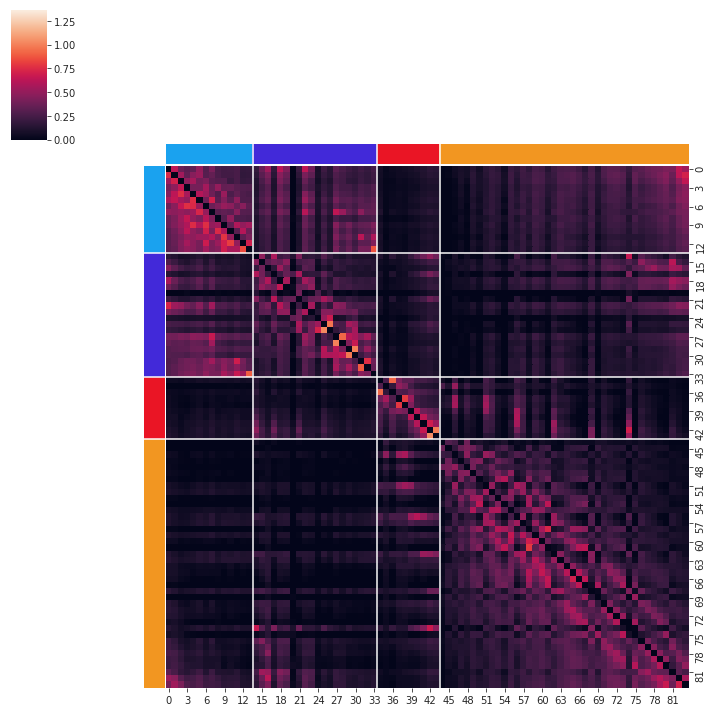

In [51]:
cg = sns.clustermap(
    data=intra[sort_l][:, sort_l],
    row_colors=colors,
    col_colors=colors,
    row_cluster=False,
    col_cluster=False,
    cmap='rocket',
    vmin=vmin,
    vmax=vmax,
)
xmax = 0
xline = 0
for name in major_labels:
    xmax += len(g2l[name])
    xline += len(g2l[name])
    if xmax >= len(sort_l) or xline >= len(sort_l):
        break
    cg.ax_heatmap.axvline(xline, color='white')
    cg.ax_col_colors.axvline(xline, color='white')

    cg.ax_heatmap.axhline(xline, color='white')
    cg.ax_row_colors.axhline(xline, color='white')

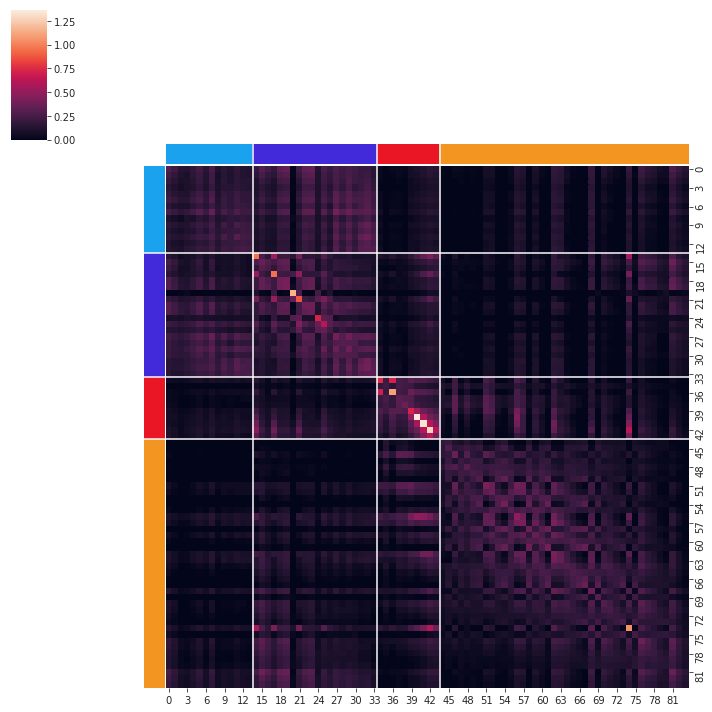

In [52]:
cg = sns.clustermap(
    data=inter[sort_l][:, sort_l],
    row_colors=colors,
    col_colors=colors,
    row_cluster=False,
    col_cluster=False,
    cmap='rocket',
    vmin=vmin,
    vmax=vmax,
)
xmax = 0
xline = 0
for name in major_labels:
    xmax += len(g2l[name])
    xline += len(g2l[name])
    if xmax >= len(sort_l) or xline >= len(sort_l):
        break
    cg.ax_heatmap.axvline(xline, color='white')
    cg.ax_col_colors.axvline(xline, color='white')

    cg.ax_heatmap.axhline(xline, color='white')
    cg.ax_row_colors.axhline(xline, color='white')

In [53]:
net = Network(mice, mode='ca2').load_network(full=False)
a = net.adj.copy()
a[a < 0] = 0

intra_l = a[net.l_ids][:, net.l_ids]
intra_r = a[net.r_ids][:, net.r_ids]

intra = intra_l.copy()
upper = np.triu_indices_from(intra_l)
intra[upper] = intra_r[upper]
np.fill_diagonal(intra, 1.0)

inter = a[net.l_ids][:, net.r_ids]

intra, inter = map(np.arctanh, (intra, inter))
intra[~np.isfinite(intra)] = 0.0
inter[~np.isfinite(inter)] = 0.0

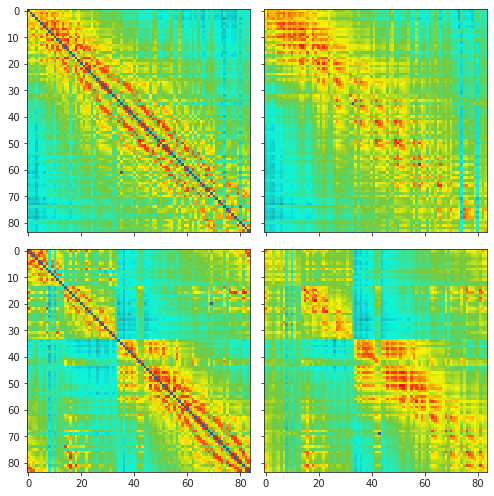

In [54]:
fig, axes = create_figure(2, 2, (7, 7), 'all', 'all')
axes[0, 0].imshow(intra, cmap=cmap_adj)
axes[0, 1].imshow(inter, cmap=cmap_adj)

axes[1, 0].imshow(intra[sort_l][:, sort_l], cmap=cmap_adj)
axes[1, 1].imshow(inter[sort_l][:, sort_l], cmap=cmap_adj)

plt.show()

In [55]:
vmin = min(np.min(intra), np.min(inter))
vmax = max(np.max(intra), np.max(inter))
vmin, vmax

(0.0, 2.013542571624521)

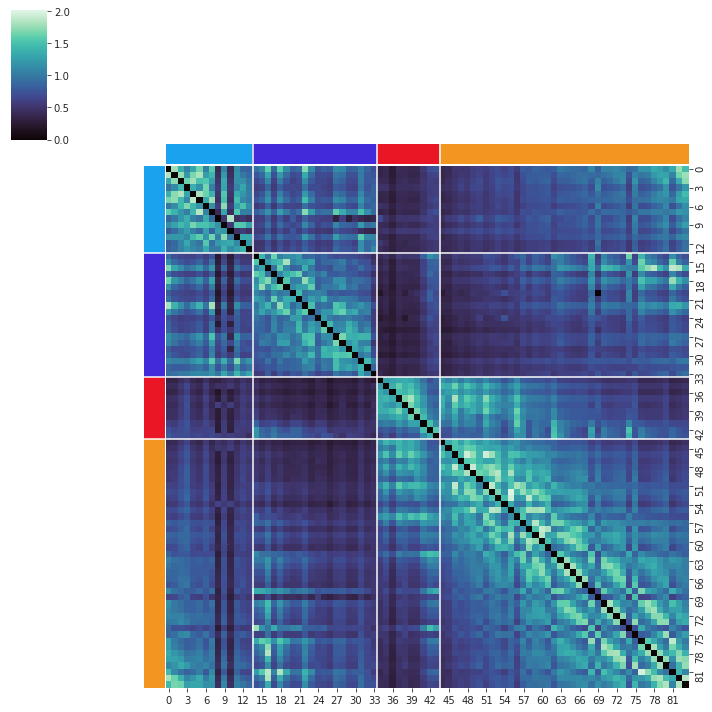

In [56]:
cg = sns.clustermap(
    data=intra[sort_l][:, sort_l],
    row_colors=colors,
    col_colors=colors,
    row_cluster=False,
    col_cluster=False,
    cmap='mako',
    vmin=vmin,
    vmax=vmax,
)
xmax = 0
xline = 0
for name in major_labels:
    xmax += len(g2l[name])
    xline += len(g2l[name])
    if xmax >= len(sort_l) or xline >= len(sort_l):
        break
    cg.ax_heatmap.axvline(xline, color='white')
    cg.ax_col_colors.axvline(xline, color='white')

    cg.ax_heatmap.axhline(xline, color='white')
    cg.ax_row_colors.axhline(xline, color='white')

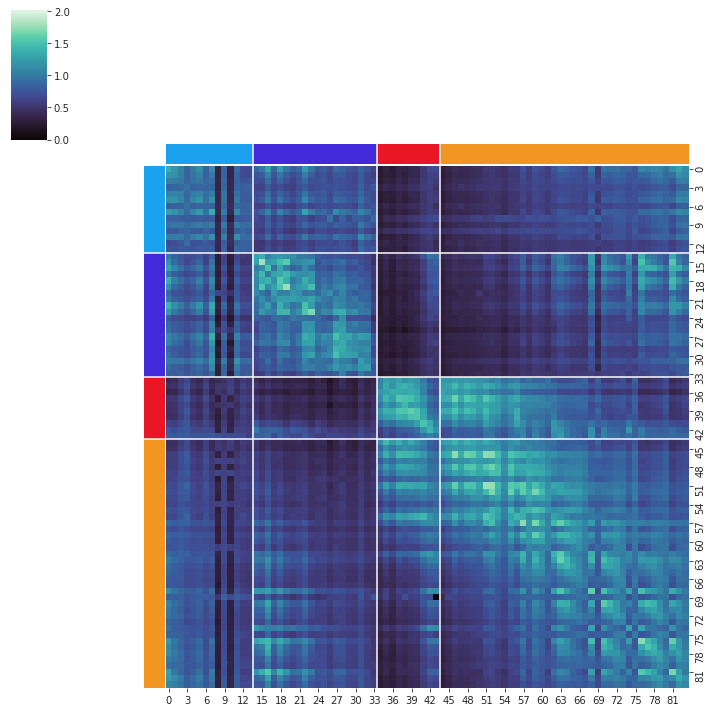

In [57]:
cg = sns.clustermap(
    data=inter[sort_l][:, sort_l],
    row_colors=colors,
    col_colors=colors,
    row_cluster=False,
    col_cluster=False,
    cmap='mako',
    vmin=vmin,
    vmax=vmax,
)
xmax = 0
xline = 0
for name in major_labels:
    xmax += len(g2l[name])
    xline += len(g2l[name])
    if xmax >= len(sort_l) or xline >= len(sort_l):
        break
    cg.ax_heatmap.axvline(xline, color='white')
    cg.ax_col_colors.axvline(xline, color='white')

    cg.ax_heatmap.axhline(xline, color='white')
    cg.ax_row_colors.axhline(xline, color='white')

## Average adjacencies

### BOLD-Lite

In [59]:
adjacencies, _ = collect_adjacencies(mice, 'bold-lite')
for i in range(len(adjacencies)):
    nans = np.abs(adjacencies[i]).mean(0) == 0
    adjacencies[i][nans] = np.nan
    adjacencies[i][:, nans] = np.nan
a = bn.nanmean(adjacencies, 0)
a[a < 0.] = 0.

In [60]:
assert not set(net.l_ids).intersection(net.r_ids)
len(net.l_ids), len(net.r_ids), a.shape

(87, 87, (174, 174))

<matplotlib.colorbar.Colorbar object at 0x7fe133a62790>

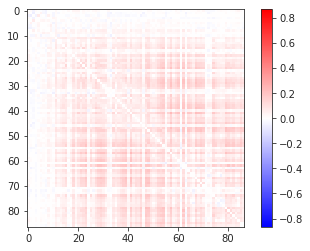

In [61]:
x = a[net.l_ids][:, net.l_ids]
y = a[net.r_ids][:, net.r_ids]
z = x - y
vminmax = np.max(np.abs(a))
plt.imshow(z, cmap='bwr', vmin=-vminmax, vmax=vminmax)
plt.colorbar()

In [62]:
intra_l = a[net.l_ids][:, net.l_ids]
intra_r = a[net.r_ids][:, net.r_ids]

intra = intra_l.copy()
upper = np.triu_indices_from(intra_l)
intra[upper] = intra_r[upper]
np.fill_diagonal(intra, 1.0)

inter = a[net.l_ids][:, net.r_ids]

intra, inter = map(np.arctanh, (intra, inter))
intra[~np.isfinite(intra)] = 0.0
inter[~np.isfinite(inter)] = 0.0

In [63]:
vmin = min(np.min(intra), np.min(inter))
vmax = max(np.max(intra), np.max(inter))
vmin, vmax

(0.0, 1.3165908620584075)

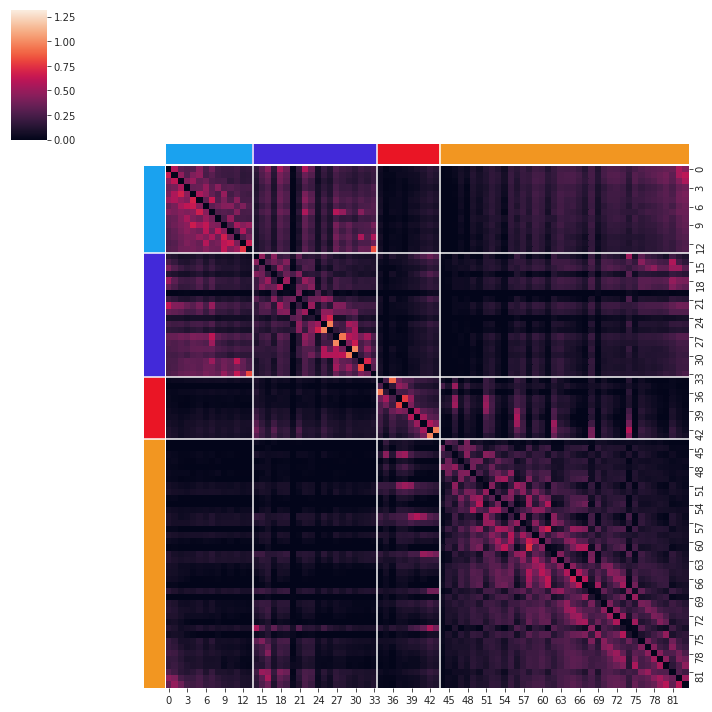

In [64]:
cg = sns.clustermap(
    data=intra[sort_l][:, sort_l],
    row_colors=colors,
    col_colors=colors,
    row_cluster=False,
    col_cluster=False,
    cmap='rocket',
    vmin=vmin,
    vmax=vmax,
)
xline = 0
for name in major_labels:
    xline += len(g2l[name])
    if xline >= len(sort_l):
        break
    cg.ax_heatmap.axvline(xline, color='white')
    cg.ax_col_colors.axvline(xline, color='white')

    cg.ax_heatmap.axhline(xline, color='white')
    cg.ax_row_colors.axhline(xline, color='white')

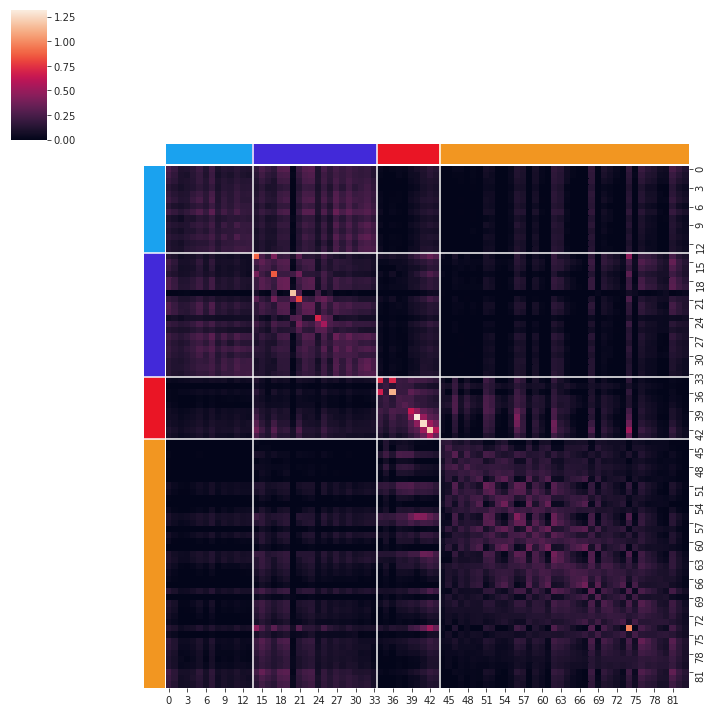

In [65]:
cg = sns.clustermap(
    data=inter[sort_l][:, sort_l],
    row_colors=colors,
    col_colors=colors,
    row_cluster=False,
    col_cluster=False,
    cmap='rocket',
    vmin=vmin,
    vmax=vmax,
)
xmax = 0
xline = 0
for name in major_labels:
    xmax += len(g2l[name])
    xline += len(g2l[name])
    if xmax >= len(sort_l) or xline >= len(sort_l):
        break
    cg.ax_heatmap.axvline(xline, color='white')
    cg.ax_col_colors.axvline(xline, color='white')

    cg.ax_heatmap.axhline(xline, color='white')
    cg.ax_row_colors.axhline(xline, color='white')

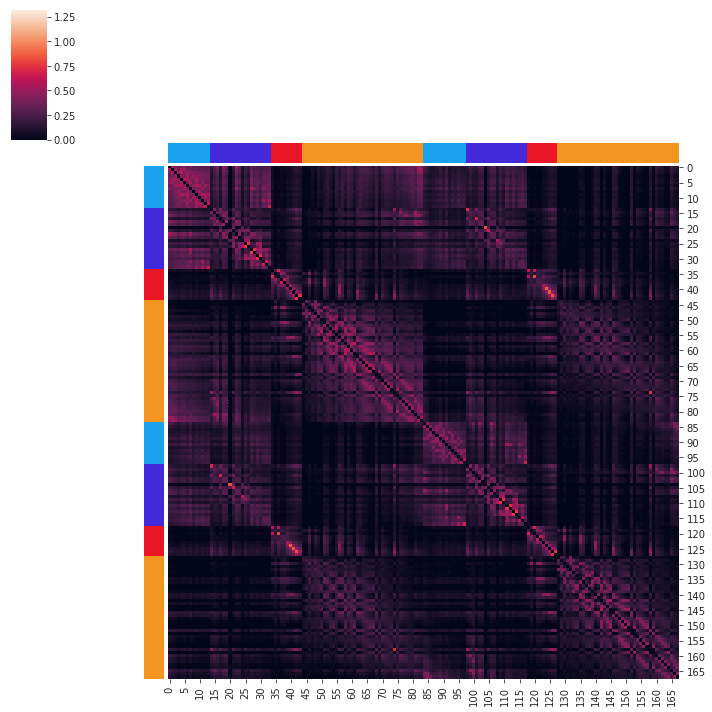

In [66]:
cg = sns.clustermap(
    data=a[sort_lr][:, sort_lr],
    row_colors=colors * 2,
    col_colors=colors * 2,
    row_cluster=False,
    col_cluster=False,
    cmap='rocket',
    vmin=vmin,
    vmax=vmax,
)

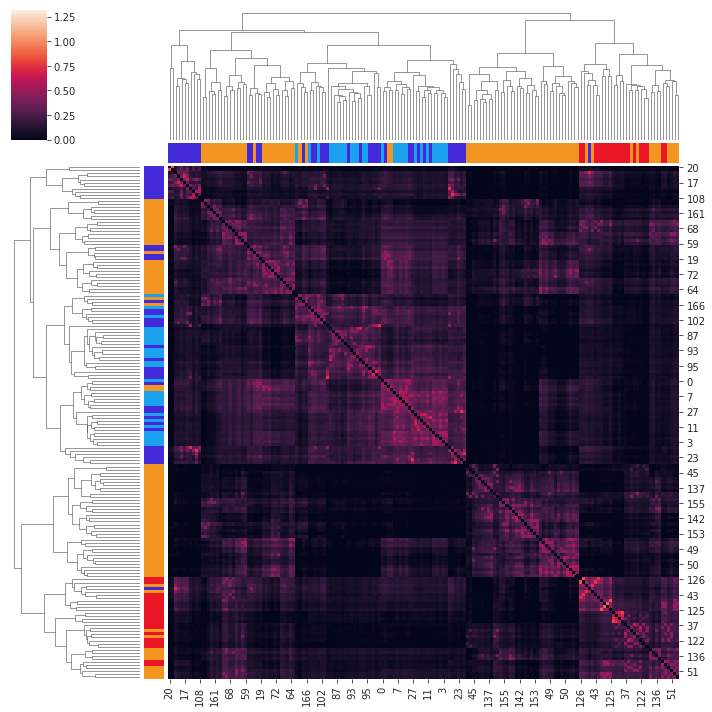

In [67]:
cg = sns.clustermap(
    data=a[sort_lr][:, sort_lr],
    row_colors=colors * 2,
    col_colors=colors * 2,
    cmap='rocket',
    vmin=vmin,
    vmax=vmax,
)

### Ca2

In [70]:
intra_l = a[net.l_ids][:, net.l_ids]
intra_r = a[net.r_ids][:, net.r_ids]

intra = intra_l.copy()
upper = np.triu_indices_from(intra_l)
intra[upper] = intra_r[upper]
np.fill_diagonal(intra, 1.0)

inter = a[net.l_ids][:, net.r_ids]

intra, inter = map(np.arctanh, (intra, inter))
intra[~np.isfinite(intra)] = 0.0
inter[~np.isfinite(inter)] = 0.0

In [71]:
vmin = min(np.min(intra), np.min(inter))
vmax = max(np.max(intra), np.max(inter))
vmin, vmax

(0.0, 2.0061810666814868)

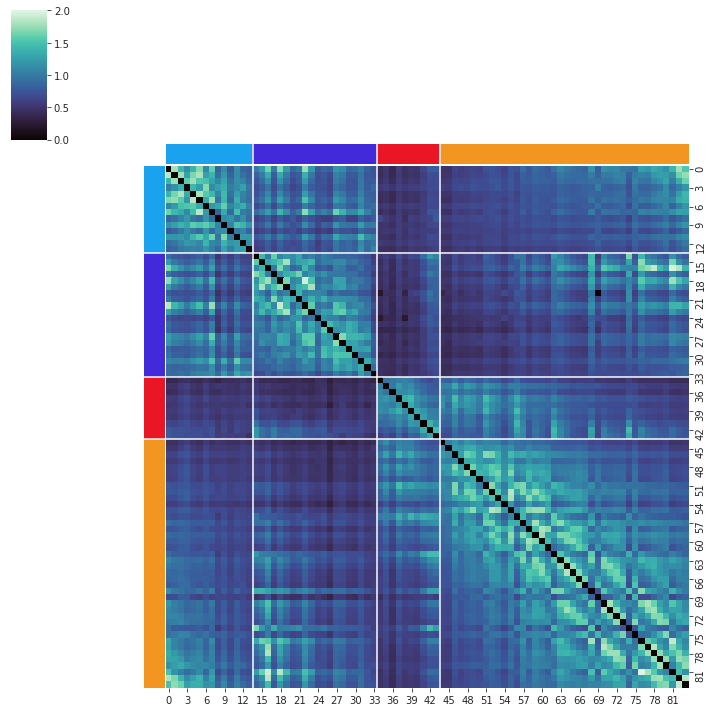

In [72]:
cg = sns.clustermap(
    data=intra[sort_l][:, sort_l],
    row_colors=colors,
    col_colors=colors,
    row_cluster=False,
    col_cluster=False,
    cmap='mako',
    vmin=vmin,
    vmax=vmax,
)
xline = 0
for name in major_labels:
    xline += len(g2l[name])
    if xline >= len(sort_l):
        break
    cg.ax_heatmap.axvline(xline, color='white')
    cg.ax_col_colors.axvline(xline, color='white')

    cg.ax_heatmap.axhline(xline, color='white')
    cg.ax_row_colors.axhline(xline, color='white')

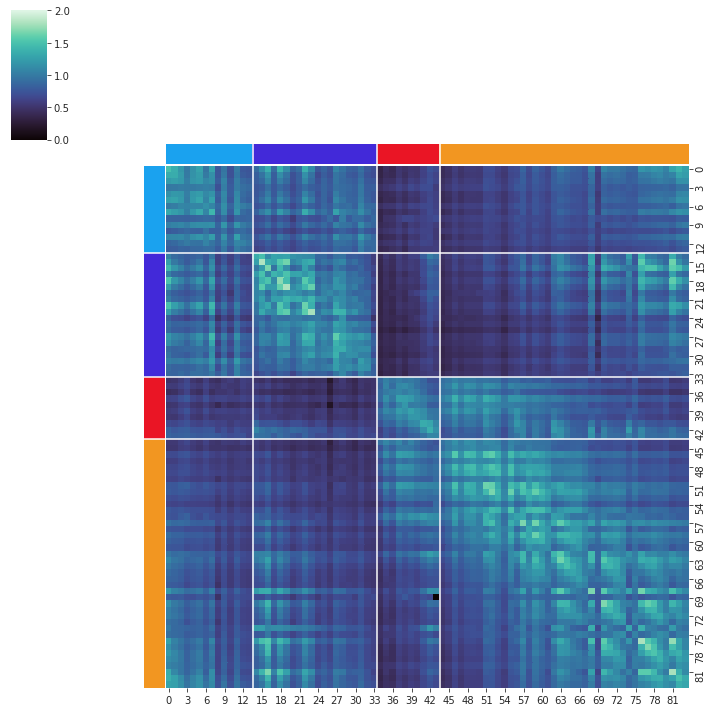

In [73]:
cg = sns.clustermap(
    data=inter[sort_l][:, sort_l],
    row_colors=colors,
    col_colors=colors,
    row_cluster=False,
    col_cluster=False,
    cmap='mako',
    vmin=vmin,
    vmax=vmax,
)
xmax = 0
xline = 0
for name in major_labels:
    xmax += len(g2l[name])
    xline += len(g2l[name])
    if xmax >= len(sort_l) or xline >= len(sort_l):
        break
    cg.ax_heatmap.axvline(xline, color='white')
    cg.ax_col_colors.axvline(xline, color='white')

    cg.ax_heatmap.axhline(xline, color='white')
    cg.ax_row_colors.axhline(xline, color='white')

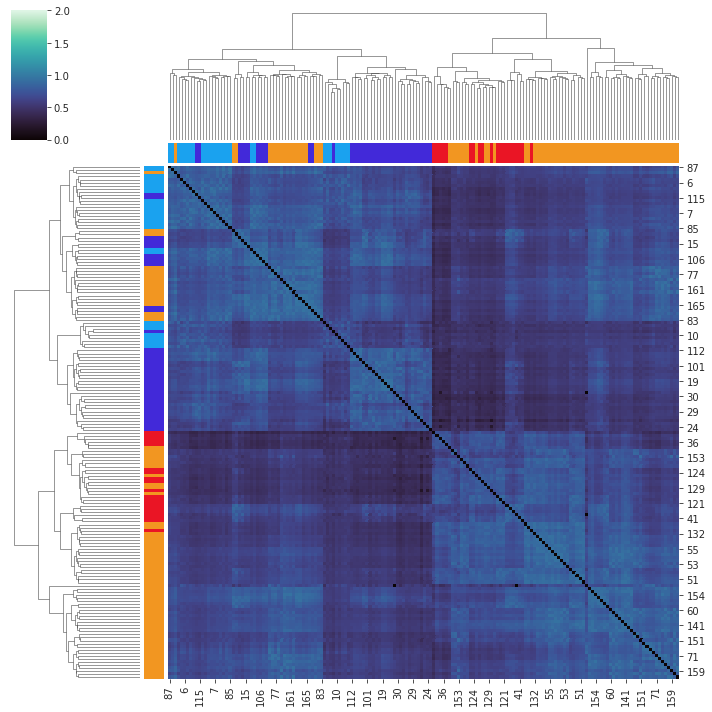

In [74]:
cg = sns.clustermap(
    data=a[sort_lr][:, sort_lr],
    row_colors=colors * 2,
    col_colors=colors * 2,
    # metric='correlation',
    cmap='mako',
    vmin=vmin,
    vmax=vmax,
)